Next, lets add an __init__.py file to the downloaded directory, so we can treat it as a module and import the MaskedAutoencoderViT class from it. Simply create an empty file inside the prithvi directory named __init__.py by running the code below

In [1]:

with open("prithvi/__init__.py", "w") as f:
    f.write("")

# Relevant imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from prithvi.Prithvi import MaskedAutoencoderViT
import pandas as pd
from functools import partial
import math
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
import torch.nn as nn
import torch.optim as optim

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

## Loading the model

In [22]:
# load weights
weights_path = "./prithvi/Prithvi_100M.pt"
checkpoint = torch.load(weights_path, map_location=torch.device('cuda:0'))

# read model config
model_cfg_path = "./prithvi/Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)

model_args, train_args = model_config["model_args"], model_config["train_params"]

# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1

model_args['img_size']= 128

# instantiate model
pretrained_model = MaskedAutoencoderViT(**model_args)
pretrained_model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = pretrained_model.load_state_dict(checkpoint, strict=False)

/tmp/ipykernel_82379/47843943.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=torch.device('cuda:0'))


In [9]:
means = np.array(train_args["data_mean"]).reshape(-1, 1, 1)
stds = np.array(train_args["data_std"]).reshape(-1, 1, 1)

# Load data

Load precipitation time series

In [11]:
BASE_PATH = '.'
data = pd.read_csv(os.path.join(BASE_PATH, 'Train.csv'))
data_test = pd.read_csv(os.path.join(BASE_PATH, 'Test.csv'))

data['event_id'] = data['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
data['event_idx'] = data.groupby('event_id', sort=False).ngroup()
data_test['event_id'] = data_test['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
data_test['event_idx'] = data_test.groupby('event_id', sort=False).ngroup()

data['event_t'] = data.groupby('event_id').cumcount()
data_test['event_t'] = data_test.groupby('event_id').cumcount()

print(data.head())
print(data_test.head())

          event_id  precipitation  label  event_idx  event_t
0  id_spictby0jfsb       0.000000      0          0        0
1  id_spictby0jfsb       0.095438      0          0        1
2  id_spictby0jfsb       1.949560      0          0        2
3  id_spictby0jfsb       3.232160      0          0        3
4  id_spictby0jfsb       0.000000      0          0        4
          event_id  precipitation  event_idx  event_t
0  id_j7b6sokflo4k        0.00000          0        0
1  id_j7b6sokflo4k        3.01864          0        1
2  id_j7b6sokflo4k        0.00000          0        2
3  id_j7b6sokflo4k       16.61520          0        3
4  id_j7b6sokflo4k        2.56706          0        4


Load satellite data

In [12]:
images_path = os.path.join(BASE_PATH, 'composite_images.npz')
images = np.load(images_path)
print(images)
print('The folder contains', len(images), 'images, both for train and test.')
print('There are', len(data['event_id'].unique()), 'train event ids and', len(data_test['event_id'].unique()), 'test event ids.')

NpzFile './composite_images.npz' with keys: id_rhg5w8vmv3ny, id_rua8ey2jczl0, id_073l04ir88sn, id_wmkfqw7iwjmu, id_heri806er7xw...
The folder contains 898 images, both for train and test.
There are 674 train event ids and 224 test event ids.


In [13]:
BAND_NAMES =  ('B2', 'B3', 'B4', 'B8', 'B11', 'slope')
# Image shape
H, W, NUM_CHANNELS = IMG_DIM = (128, 128, len(BAND_NAMES))

Preprocessing

In [14]:
sample_image = next(iter(images.values()))
assert sample_image.shape == IMG_DIM
assert sample_image.dtype == np.uint16
_MAX_INT = np.iinfo(np.uint16).max

def decode_slope(x: np.ndarray) -> np.ndarray:
  # Convert 16-bit discretized slope to float32 radians
  return (x / _MAX_INT * (math.pi / 2.0)).astype(np.float32)

def normalize(x: np.ndarray, mean: int, std: int) -> np.ndarray:
  return (x - mean) / std

rough_S2_normalize = partial(normalize, mean=1250, std=500)

def preprocess_image(x: np.ndarray) -> np.ndarray:
  return np.concatenate([
      rough_S2_normalize(x[..., :-1].astype(np.float32)),
      decode_slope(x[..., -1:]),
  ], axis=-1, dtype=np.float32)


In [15]:
rng = np.random.default_rng(seed=0xf100d)

event_ids = data['event_id'].unique()
new_split = pd.Series(
    data=np.random.choice(['train', 'valid'], size=len(event_ids), p=[0.8, 0.2]),
    index=event_ids,
    name='split',
)
data_new = data.join(new_split, on='event_id')

train_df = data_new[(data_new['split'] == 'train')]
train_timeseries = train_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
train_labels = train_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

valid_df = data_new[data_new['split'] == 'valid']
valid_timeseries = valid_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
valid_labels = valid_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

# For the test set there are no labels
test_timeseries = data_test.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()

event_splits = data_new.groupby('event_id')['split'].first()

In [16]:
b,t= train_timeseries.shape
train_timeseries_tensor= torch.from_numpy(train_timeseries).to(torch.float32).view(b, 1, t)

In [17]:
train_labels_tensor= torch.from_numpy(train_labels).to(torch.float32)

In [18]:
train_images = []
valid_images = []
test_images = []

for event_id in event_splits.index:
  img = preprocess_image(images[event_id])
  if event_splits[event_id] == 'train':
    train_images.append(img)
  else:
    valid_images.append(img)

for event_id in data_test['event_id'].unique():
  img = preprocess_image(images[event_id])
  test_images.append(img)

train_images = np.stack(train_images, axis=0)
valid_images = np.stack(valid_images, axis=0)
test_images = np.stack(test_images, axis=0)

In [19]:
train_images_tensor= torch.from_numpy(train_images).permute([0, 3, 1, 2]).to(torch.float32).reshape(train_images.shape[0], 6, 1, 128, 128)

In [20]:
normalized= train_images_tensor[0].view(1,6,1,128,128)
with torch.no_grad():
        mask_ratio = 0.5
        loss, pred, mask = model(normalized, mask_ratio=mask_ratio)
        print('loss:', loss)
        mask_img = model.unpatchify(mask.unsqueeze(-1).repeat(1, 1, pred.shape[-1])).detach().cpu()
        pred_img = model.unpatchify(pred).detach().cpu()

loss: tensor(0.2105)


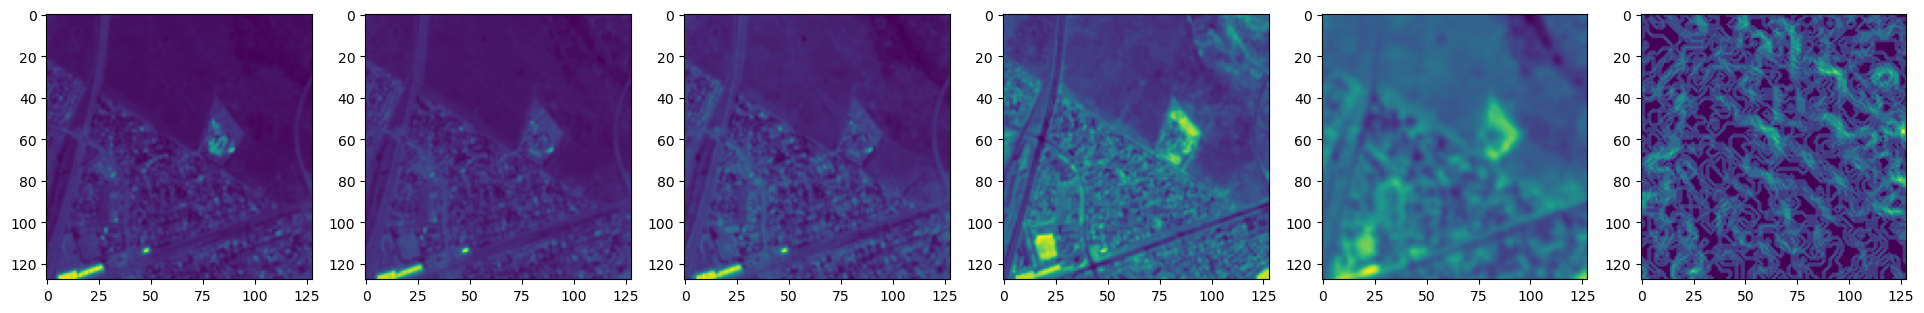

In [25]:
fig, axes= plt.subplots(1,6,figsize=(24,4))
for c in range(6):
    ax=axes[c]
    ax.imshow(normalized.numpy().squeeze()[c])
plt.show();

In [36]:
mask_img.shape

torch.Size([1, 6, 1, 128, 128])

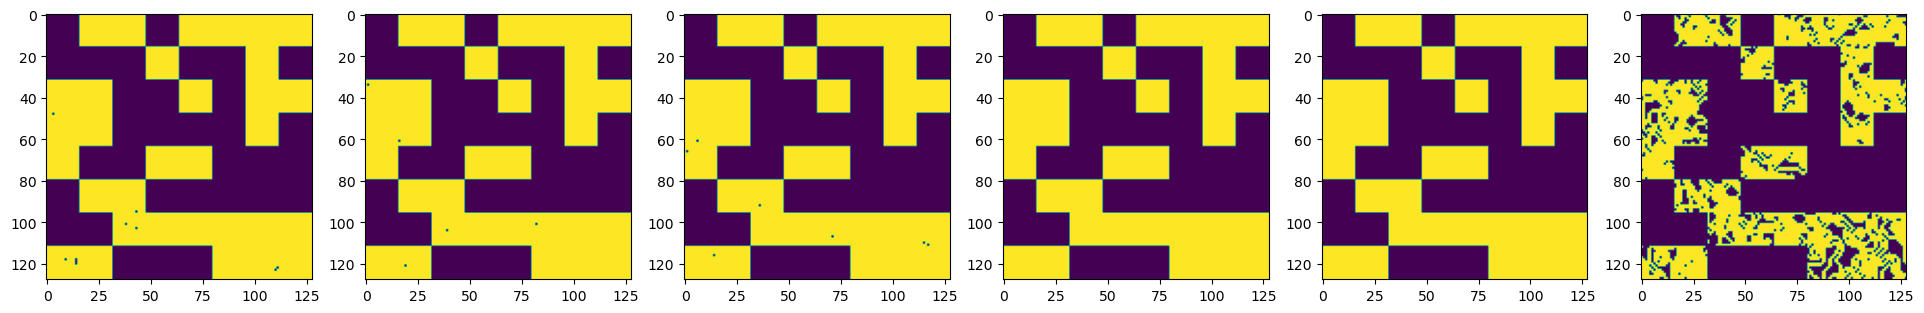

In [31]:
fig, axes= plt.subplots(1,6,figsize=(24,4))
for c in range(6):
    ax=axes[c]
    ax.imshow(np.where(normalized.numpy().squeeze()[c], mask_img.numpy().squeeze()[c], 0))
plt.show();

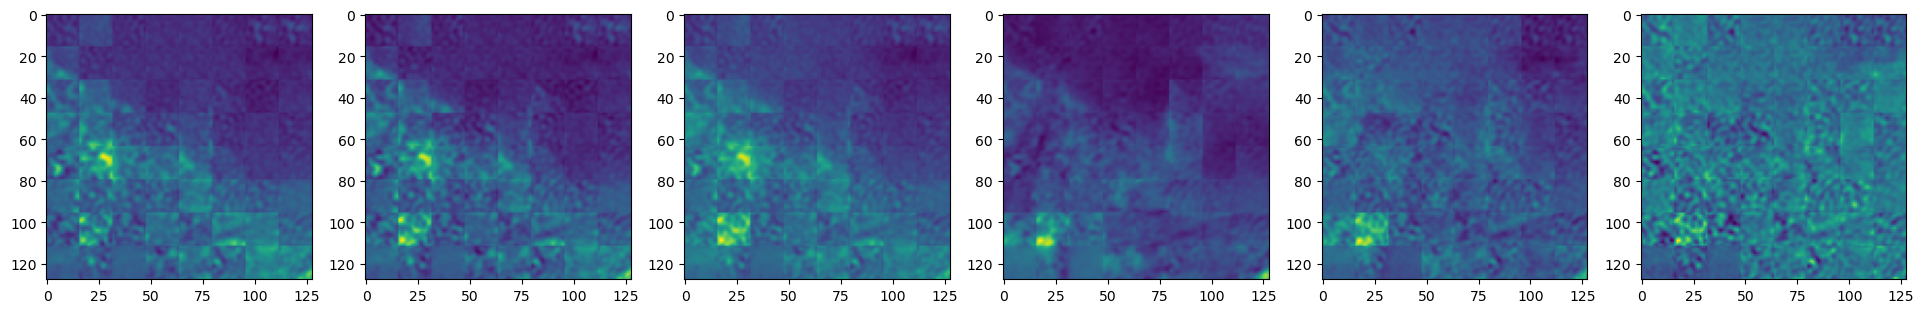

In [24]:
fig, axes= plt.subplots(1,6,figsize=(24,4))
for c in range(6):
    ax=axes[c]
    ax.imshow(pred_img.numpy().squeeze()[c])
plt.show();

In [16]:
def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., 0]

    return channels_last

def plot_image_mask_reconstruction(normalized, mask_img, pred_img):
    # Mix visible and predicted patches
    rec_img = normalized.clone()
    rec_img[mask_img == 1] = pred_img[mask_img == 1]  # binary mask: 0 is keep, 1 is remove

    mask_img_np = mask_img.numpy().squeeze().transpose((1, 2, 0))[..., 0]

    rec_img_np = (rec_img.numpy().squeeze() * stds) + means
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    for subplot in ax:
        subplot.axis('off')

    ax[0].imshow(enhance_raster_for_visualization(train_images[0].transpose((2,0,1))))
    masked_img_np = enhance_raster_for_visualization(train_images[0].transpose((2,0,1))).copy()
    masked_img_np[mask_img_np == 1] = 0
    ax[1].imshow(masked_img_np)
    ax[2].imshow(enhance_raster_for_visualization(pred_img.numpy().squeeze(), ref_img=train_images[0].transpose((2,0,1))))

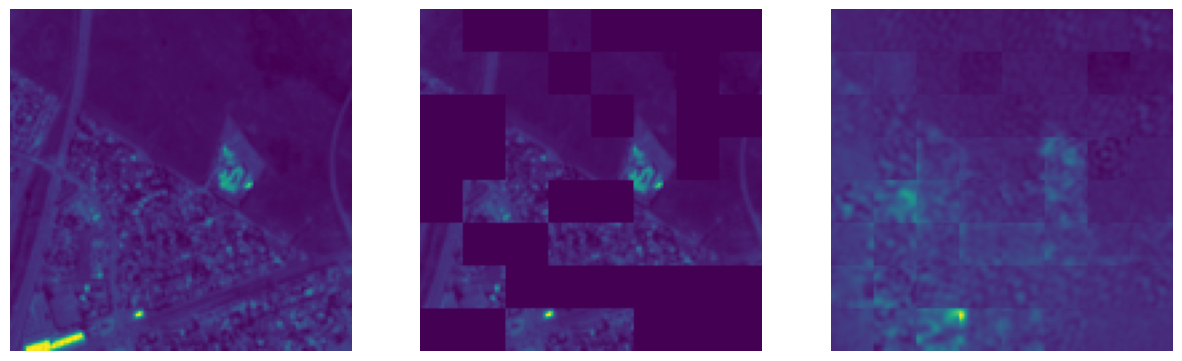

In [66]:
plot_image_mask_reconstruction(normalized, mask_img, pred_img)

## Fine tune my model!

In [82]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize

class LoadData(Dataset):
    def __init__(self, transform=None):
        """
        Args:
            data (torch.Tensor): Input images, shape (num_samples, channels, height, width)
            labels (torch.Tensor): Labels, shape (num_samples, num_classes) or (num_samples,)
            transform (callable, optional): Optional transform to apply to data
        """
        super(LoadData, self).__init__()
        self.data = train_images_tensor
        self.labels = train_labels_tensor
        self.ts= train_timeseries_tensor.squeeze()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        t = self.ts[idx]
        y = self.labels[idx]
        if self.transform:
            # apply log gausian transformation to my rainfall data
            epsilon= 1e-6
            t_log= torch.log(t + epsilon)
            feature_mean = t_log.mean(dim=0, keepdim=True)
            feature_std = t_log.std(dim=0, keepdim=True)
            feature_std[feature_std == 0] = 1.0  # Avoid division by zero
            t = (t_log - feature_mean) / feature_std
        return x, t, y


In [71]:
import torch.nn as nn
import torch.optim as optim

In [116]:
#Combine pretrained model and fine-tuned model
class FloodViT(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(FloodViT, self).__init__()
        
        # Copy components from the pretrained model
        self.pretrained_model= pretrained_model
        # features, _, _ = model.forward_encoder(normalized, mask_ratio=0)
        
        # Define a global pooling layer and fully connected layer for classification


        self.fcl1= nn.Linear(49152, 730)
        self.fcl2= nn.Linear(730*2, 730)
        self.relu= nn.ReLU()
        self.batchnorm= nn.BatchNorm1d(1460)

    def forward(self, x, t):
        # Preprocessing and patch embedding
        x,_,_= self.pretrained_model.forward_encoder(x, mask_ratio=0)
        b, token, e= x.shape
        b, it= t.squeeze().shape
        # Reshape to spatial dimensions: (batch_size, channels, height, width)
        x = x[:, 1:, :].view(b, -1)
        x= self.fcl1(x)
        x= self.relu(x)
        # t= self.batchnorm(t)
        x= torch.concat([x, t], dim=-1)
        x= self.batchnorm(x)
        x= self.fcl2(x)
        x= self.relu(x)
        
        return x

In [172]:
new_model= FloodViT(model, 1)
# Freeze pretrained_model parameters
for name, param in new_model.named_parameters():
    if name.startswith("pretrained_model") or name.startswith('decoder'):
        param.requires_grad = False

# Verify trainable parameters
print("Trainable parameters after freezing pretrained_model:")
for name, param in new_model.named_parameters():
    if param.requires_grad:
        print(f"Name: {name}, Shape: {param.shape}")

Trainable parameters after freezing pretrained_model:
Name: fcl1.weight, Shape: torch.Size([730, 49152])
Name: fcl1.bias, Shape: torch.Size([730])
Name: fcl2.weight, Shape: torch.Size([730, 1460])
Name: fcl2.bias, Shape: torch.Size([730])
Name: batchnorm.weight, Shape: torch.Size([730])
Name: batchnorm.bias, Shape: torch.Size([730])


In [110]:
b=3
new_model(train_images_tensor[:b].view(b,6,1,128,128).to(device), train_timeseries_tensor[:b].view(b,730).to(device)).sum(dim=1)

tensor([106.5020,  18.6882,   0.0000], device='cuda:0', grad_fn=<SumBackward1>)

In [173]:
pos_weight = torch.tensor([5.0]).to(device)
criterion= nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer= optim.AdamW(new_model.parameters(), lr=1e-3)

In [174]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model= new_model.to(device)
model= model.to(device)
dataset = LoadData(transform=True)

# Create DataLoader for batch processing
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100  # Number of epochs
for epoch in range(num_epochs):
    new_model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, t, label in train_loader:
        inputs, t, label = inputs.to(device), t.to(device), label.to(device)  # Move data to GPU/CPU
        
        pred= new_model(inputs, t)

        loss= criterion(pred, label)


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item()

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Pred: {pred.sum()}, Label: {label.sum()}")

Epoch [1/100], Loss: 0.7027, Pred: 0.0, Label: 10.0
Epoch [2/100], Loss: 0.6950, Pred: 0.0, Label: 11.0
Epoch [3/100], Loss: 0.6950, Pred: 0.0, Label: 14.0
Epoch [4/100], Loss: 0.6950, Pred: 0.0, Label: 11.0
Epoch [5/100], Loss: 0.6950, Pred: 0.0, Label: 10.0
Epoch [6/100], Loss: 0.6950, Pred: 0.0, Label: 15.0
Epoch [7/100], Loss: 0.6950, Pred: 0.0, Label: 10.0
Epoch [8/100], Loss: 0.6950, Pred: 0.0, Label: 12.0
Epoch [9/100], Loss: 0.6950, Pred: 0.0, Label: 13.0
Epoch [10/100], Loss: 0.6950, Pred: 0.0, Label: 6.0
Epoch [11/100], Loss: 0.6950, Pred: 0.0, Label: 13.0
Epoch [12/100], Loss: 0.6950, Pred: 0.0, Label: 8.0
Epoch [13/100], Loss: 0.6950, Pred: 0.0, Label: 12.0
Epoch [14/100], Loss: 0.6950, Pred: 0.0, Label: 12.0
Epoch [15/100], Loss: 0.6950, Pred: 0.0, Label: 10.0
Epoch [16/100], Loss: 0.6950, Pred: 0.0, Label: 10.0
Epoch [17/100], Loss: 0.6950, Pred: 0.0, Label: 8.0
Epoch [18/100], Loss: 0.6950, Pred: 0.0, Label: 10.0
Epoch [19/100], Loss: 0.6950, Pred: 0.0, Label: 13.0
Epoch

KeyboardInterrupt: 

# Prepare submission

In [5]:
class FloodViT(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(FloodViT, self).__init__()
        
        # Copy components from the pretrained model
        self.pretrained_model= pretrained_model
        # features, _, _ = model.forward_encoder(normalized, mask_ratio=0)
        
        # Define a global pooling layer and fully connected layer for classification


        self.fcl1= nn.Linear(49152, 730)
        self.fcl2= nn.Linear(730*2, 730)
        self.relu= nn.ReLU()
        self.batchnorm= nn.BatchNorm1d(1460)

    def forward(self, x, t):
        # Preprocessing and patch embedding
        x,_,_= self.pretrained_model.forward_encoder(x, mask_ratio=0)
        b, token, e= x.shape
        b, it= t.squeeze().shape
        # Reshape to spatial dimensions: (batch_size, channels, height, width)
        x = x[:, 1:, :].view(b, -1)
        x= self.fcl1(x)
        x= self.relu(x)
        # t= self.batchnorm(t)
        x= torch.concat([x, t], dim=-1)
        x= self.batchnorm(x)
        x= self.fcl2(x)
        x= self.relu(x)
        
        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model and optimizer
model = FloodViT(pretrained_model, 1).to(device)

# Load the checkpoint
checkpoint = torch.load("checkpoints/model_state.pth", map_location='cuda')

# Restore state
model.load_state_dict(checkpoint)

model.eval()  # Set the model to training mode

/tmp/ipykernel_82379/3333571828.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/model_state.pth", map_location='cuda')


FloodViT(
  (pretrained_model): MaskedAutoencoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((

In [30]:

test_images_tensor= torch.from_numpy(test_images).permute([0, 3, 1, 2]).to(torch.float32).reshape(test_images.shape[0], 6, 1, 128, 128)
b,t= test_timeseries.shape
test_timeseries_tensor= train_timeseries_tensor= torch.from_numpy(test_timeseries).to(torch.float32).view(b, 1, t)

In [33]:
test_images_tensor.shape

torch.Size([224, 6, 1, 128, 128])

In [34]:
test_timeseries_tensor.shape

torch.Size([224, 1, 730])

In [41]:
test_labels= model(test_images_tensor.to(device), test_timeseries_tensor.to(device).squeeze()).cpu().detach().numpy()

In [43]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

probs = sigmoid(test_labels)
probs.shape

(224, 730)

In [47]:
sample_submission.label.max()

1.0

In [44]:
sample_submission = pd.read_csv(BASE_PATH + '/SampleSubmission.csv')
sample_submission['label'] = probs.flatten()
sample_submission.head()

,event_id,label
0,id_j7b6sokflo4k_X_0,0.544915
1,id_j7b6sokflo4k_X_1,0.500000
2,id_j7b6sokflo4k_X_2,0.500000
3,id_j7b6sokflo4k_X_3,0.500000
4,id_j7b6sokflo4k_X_4,0.500000


In [48]:
sample_submission.to_csv('BenchmarkSubmission.csv', index = False)